# Uniform seeding of the Caribbean 

**No weight** assigned to particle

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import path, colors
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import urllib.request
import skimage.io as io
import copy
import os
from os.path import join
from datetime import datetime
import scipy as sc
from scipy import stats
import xarray as xr
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import generic_filter
import shapely
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cmocean
import numba as nb

In [2]:
import sys
sys.path.append('/nexsan/people/pmiron/projects_mars/HYCOM-utilities/python/')
import hycom.io as hio

In [8]:
caribbean_countries = [ # countries
    'Antigua and Barbuda', 'Bahamas', 'Barbados',
    'Cuba', 'Dominica', 'Dominican Republic',
    'Grenada', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis',
    'Saint Lucia', 'Saint Vincent and the Grenadines',
    'Trinidad and Tobago',
    # dependant teritory
    'Anguilla', 'Aruba',
    'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands', 'Cayman Islands',
    'Curaçao', 'Guadeloupe', 'Martinique',
    'Montserrat', 'Puerto Rico', 'Saint-Barthélemy',
    'Saint-Martin', 'Sint Maarten',
    'Turks and Caicos Islands', 'Virgin Islands, U.S.',
    # other countries
    'Mexico', 'United States', 'Venezuela', 'Belize', 'Colombia',
    'Costa Rica', 'Guatemala', 'Guyana', 'Honduras', 'Nicaragua', 'Panama',
    'Suriname']

# Dataframe with MPW estimates from Jambeck et al

In [4]:
xc = np.array([-51.6, -76.8, -78, -79.3, -81, -82.7, -87.3, -98.5, -98.5, -66.7, -51.6, -51.6])
yc = np.array([3.5, 7, 8.6, 9.2, 8.2, 8.8, 14.8, 19.0, 31.0, 31.0, 31.0, 3.9])
p = path.Path(np.vstack((xc, yc)).T)
    
def caribbean_filter(x, y):
    '''
    Return mask to filter particles on the Pacific Ocean coast    
    '''
    return p.contains_points(np.column_stack((x, y)))

def gridcell_country(c_id):
    '''
    Return (qlon, qlat) of gridcell of a given country
    '''
    with xr.open_dataset('../data/process/country_GLBv0.08.nc') as ds:
        plon = ds.plon
        plat = ds.plat
        
        ocean_coast = (ds.ocean_coastlines_country == c_id)
        j, i = np.where(ocean_coast)
        return i, j, plon[i], plat[j]    

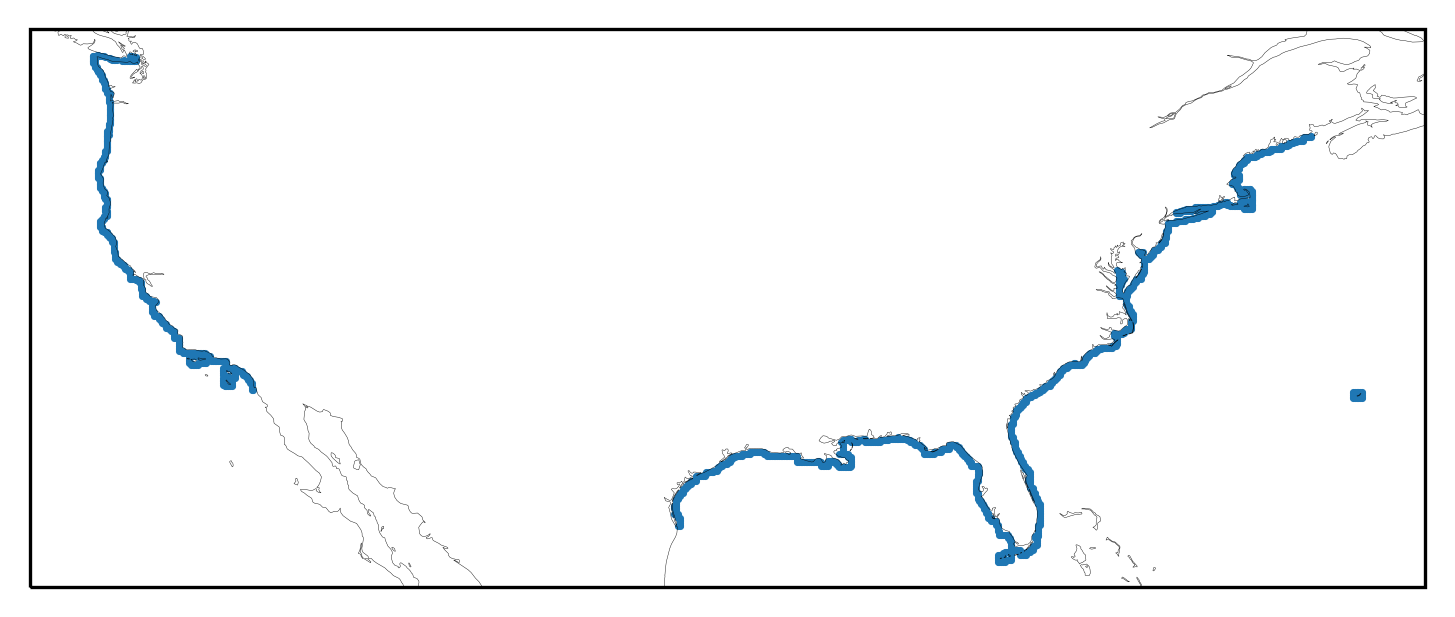

In [5]:
# uniform mpw in the region
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

c_id = 29  # mexico 28, usa 29
i,j,x,y = gridcell_country(c_id)

ax.scatter(x, y, s=0.5, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Generate particles uniformly for each country around the coastline

In [9]:
ds = xr.open_dataset('../data/process/country_GLBv0.08.nc')
qlon = ds.qlon.values
qlat = ds.qlat.values
ds.close()

np.random.seed(42)
coast_x = []; coast_y = []; coast_cid = []

n = 5  # constant number of particles

for c_id in range(0, len(caribbean_countries)):    
    i,j,plon,plat = gridcell_country(c_id)
    k = caribbean_filter(plon,plat)
    i,j,plon,plat = i[k],j[k],plon[k],plat[k]  

    for i,j in zip(i,j):
        dx = qlon[i+1] - qlon[i]
        dy = qlat[j+1] - qlat[j]

        coast_x.append(qlon[i] + np.random.random_sample(n) * dx)
        coast_y.append(qlat[j] + np.random.random_sample(n) * dy)
        coast_cid.append(np.full(n, c_id, dtype='int'))
            
coast_x = np.hstack(coast_x)
coast_y = np.hstack(coast_y)
coast_cid = np.hstack(coast_cid)

In [10]:
print(f'A total of {len(coast_x)} uniform particles.')

A total of 20740 uniform particles.


In [13]:
land = xr.open_dataset('../data/process/land_GLBv0.08.nc').land.values
qlon = xr.open_dataset('../data/process/land_GLBv0.08.nc').qlon.values 
qlat = xr.open_dataset('../data/process/land_GLBv0.08.nc').qlat.values 

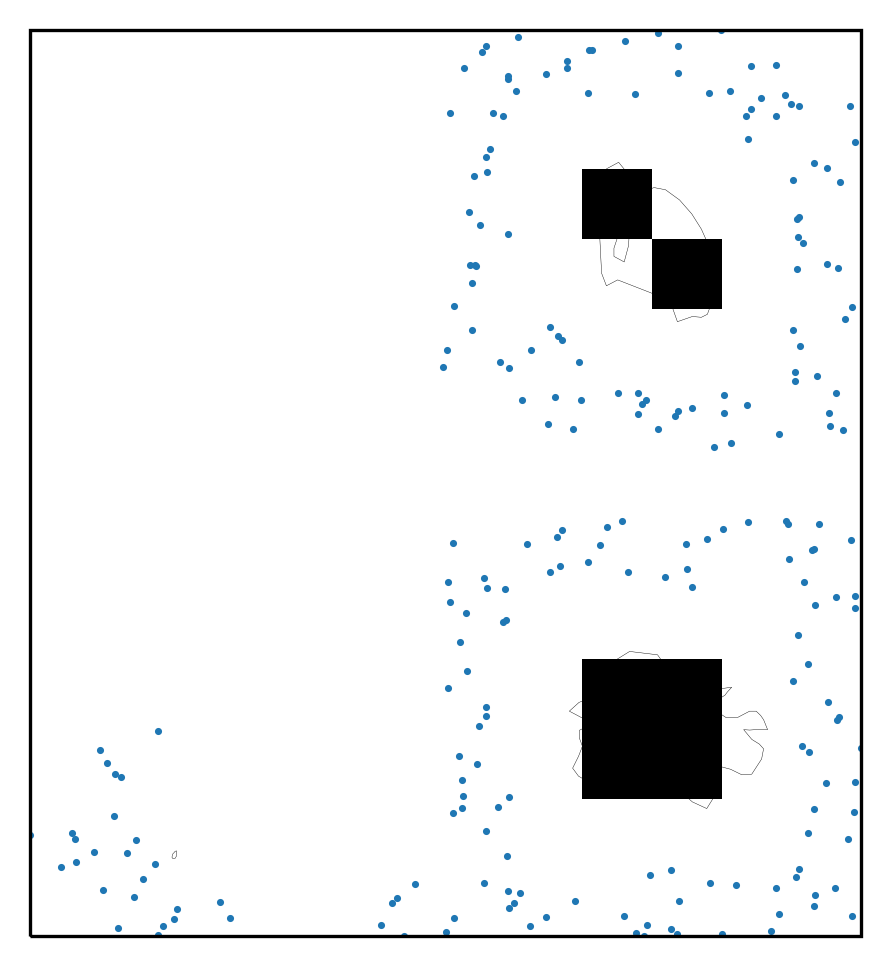

In [18]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1,aspect='equal', projection=ccrs.PlateCarree())

c_id = 0
r = np.where(coast_cid == c_id)[0]

ax.pcolormesh(qlon, qlat, land, transform=ccrs.PlateCarree(), cmap='binary')
ax.scatter(coast_x[r], coast_y[r], s=0.5, transform=ccrs.PlateCarree())

ax.set_xlim(np.min(coast_x[r]), np.max(coast_x[r]))
ax.set_ylim(np.min(coast_y[r]), np.max(coast_y[r]))

ax.add_feature(cfeature.COASTLINE, linewidth=0.1, zorder=1)

# Export csv per country

In [24]:
# coast
df_c = pd.DataFrame({
    'longitude': coast_x,
    'latitude': coast_y,
    'country id': coast_cid,
    })

output_folder = '../data/process/'
df_c.to_csv(join(output_folder, f"coasts_uniform.csv"), index=False)

In [22]:
for i, c in enumerate(caribbean_countries):
    r = np.where(coast_cid == i)

    # coast
    df_c = pd.DataFrame({
        'longitude': coast_x[r],
        'latitude': coast_y[r],
        'country id': coast_cid[r],
        })
    
    output_folder = '../data/process/uniform_per_country'
    df_c.to_csv(join(output_folder, f"c{i:02d}_{c.replace(',', '').lower().replace(' ', '-')}.csv"), index=False)